In [16]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tqdm import tqdm_notebook

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

(-0.5, 27.5, 27.5, -0.5)

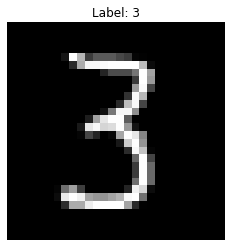

In [18]:
# Visualize an example from the dataset

idx = np.random.randint(X_train.shape[0])
plt.imshow(X_train[idx, : ], cmap= 'gray')
plt.title('Label: {}'.format(y_train[idx]))
plt.axis('off')

In [19]:
# IMPORTANT: RUN THIS CELL ONLY ONCE!
# Add dimension to images
X_train = np.expand_dims(X_train, axis = 1)
X_test = np.expand_dims(X_test, axis = 1)

----- Layers for our network ------

In our model for simplicity, we includes 4 most importants layers to achieve the desire prediction


1.   Convolution Layers

2.   Rectified Linear Unit (ReLU)

3.   Max Pooling Layers

4.   Set of fully connected layers





In [20]:
# In each layer, we include a forward pass and a backpropagation to simplify the computation
def conv_forward(x,w,b):
  """
    Perform convolutional forward pass.
    x: input of shape (N, C, H, W)
    w: filters of shape (F, C, FH, FW)
    b: bias terms of shape (F, )
  """
  N, C, H, W = x.shape 
  F, _, FH, FW = w.shape

  # Orther parameters. Set so that the input shape remains unchanged

  stride = 1                  # stride to apply filter
  padding =  (FH - 1) // 2     # padding on each side 

  out = np.zeros((N, F, H, W))

  padded_x = np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
  _, _, padded_H, padded_W = padded_x.shape

  x_col = np.zeros((C * FH * FW, H * W))
  w_row = w.reshape(F, C * FH * FW)

  for i in range(N):
    c = 0
    for j in range(0, padded_H - FH + 1, stride):
      for k in range(0, padded_W - FW + 1, stride):
        x_col[:, c] = padded_x[i, :, j:j+FH, k:k+FW].reshape(C * FH * FW)
        c += 1
    out[i, :] = (np.dot(w_row, x_col) + b.reshape(-1, 1)).reshape(F, H, W)
  
  cache = (x, w, b, stride, padding)
  return out, cache 


In [21]:
def conv_backward(dout, cache):
  """
  Perform convolutional backpropagation
  dout: downstream derivative
  cache: caches from foward pass 
  """
  x, w, b, stride, padding = cache 
  N, C, H, W = x.shape 
  F, _, FH, FW = w.shape 

  padded_x = np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
  _, _, padded_H, padded_W = padded_x.shape

  dx = np.zeros_like(x)
  dw = np.zeros_like(w)
  db = np.zeros_like(b) 

  x_col = np.zeros((C * FH * FW, H * W))
  w_row = w.reshape(F, C * FH * FW)

  for i in range(N):
    curr_dout = dout[i, :, :, :].reshape(F, H * W)
    curr_out = np.dot(w_row.T, curr_dout)
    curr_dpx = np.zeros(padded_x.shape[1:])
    c = 0
    for j in range(0, padded_H - FH + 1, stride):
      for k in range(0, padded_W - FW + 1, stride):
        curr_dpx[:, j:j+FH, k:k+FW] += curr_out[:, c].reshape(C, FH, FW)
        x_col[:, c] = padded_x[i, :, j:j+FH, k:k+FW].reshape(C * FH * FW) 
        c += 1
    dx[i] = curr_dpx[:, padding:-padding, padding:-padding]
    dw += np.dot(curr_dout, x_col.T).reshape(F, C, FH, FW)
    db += np.sum(curr_dout, axis=1)

  return dx, dw, db

In [22]:
def relu_forward(x):
  """
  ReLU activation forward pass.
  x: input of shape(N, C, H, W)

  """
  out = np.maximum(x,0)
  cache = x
  return out, cache

In [23]:
def relu_backward(dout, cache):
  """
  ReLU backpropagation
  dout: downstream derivative
  cache: cache from forward pass
  """

  x = cache
  dx = dout * (x > 0)

  return dx

In [24]:
def max_pool_forward (x, shape=[2,2], stride=2):
  """
  Max pooling layer forward pass.
  x: input of shape(N, C, H, W)
  shape: shape of the pooling region
  stride = stride to apply pooling
  """

  N, C, H, W = x.shape
  pool_height, pool_width = shape
  out_H = 1 + (H - pool_height) // stride
  out_W = 1 + (W - pool_width) // stride

  out = np.zeros((N, C, out_H, out_W))

  for i in range(N):
    curr_out = np.zeros((C, out_H * out_W))
    c = 0
    for j in range(0, H - pool_height + 1, stride):
      for k in range(0, W - pool_width + 1, stride):
        curr_region = x[i, :, j:j+pool_height, k:k+pool_width].reshape(C, pool_height * pool_width)
        curr_max_pool = np.max(curr_region, axis = 1)
        curr_out[:, c] = curr_max_pool
        c += 1
    out[i,:,:,:] = curr_out.reshape(C, out_H, out_W)
  cache = (x, pool_height, pool_width, stride)
  return out, cache

In [25]:
def max_pool_backward(dout, cache):
  """
  Max pooling layer backpropagation
  dout: downstream derivative
  cache: cache from forward pass

  """

  x, pool_height, pool_width, stride = cache
  N, C, H, W = x.shape
  _,_, out_H, out_W = dout.shape

  dx = np.zeros_like(x)

  for i in range(N):
    curr_dout = dout[i, :].reshape(C, out_H * out_W)
    c = 0
    for j in range(0, H - pool_height + 1, stride):
      for k in range(0, W - pool_width + 1, stride):
        curr_region = x[i, :, j:j+pool_height, k:k+pool_width].reshape(C, pool_height * pool_width)
        curr_max_idx = np.argmax(curr_region, axis = 1)
        curr_dout_region = curr_dout[:, c]
        curr_dpooling = np.zeros_like(curr_region)
        curr_dpooling[np.arange(C), curr_max_idx] = curr_dout_region
        dx[i, :, j:j+pool_height, k:k+pool_height] = curr_dpooling.reshape(C, pool_height, pool_width)
        c += 1

  return dx



In [26]:
def fc_forward(x, w, b):
  """
  Fully-connected layer forward pass. 
  x: input of shape (N, C, W, H)
  w: weight matrix of shape (D, M)
  b: bias of shape (M, )
  """
  N = x.shape[0]
  x_new = x.reshape(N, -1)

  out = np.dot(x_new, w) + b
  cache = (x, w, b)
  return out, cache 

In [27]:
def fc_backward(dout, cache):
  """
  Fully-connected layer backpropagation.
  dout: downstream derivative
  cache: cache from forward pass
  """
  x, w, b = cache 
  N = x.shape[0]
  x_new = x.reshape(N, -1)

  dx = np.dot(dout, w.T).reshape(x.shape)
  dw = np.dot(x_new.T, dout)
  db = np.sum(dout.T, axis=1)
  return dx, dw, db

In [28]:
def softmax_loss(x, y):
  N = x.shape[0]

  # stable softmax
  x = x - np.max(x, axis=1, keepdims=True)
  numerator = np.exp(x)
  probs = numerator / np.sum(numerator, axis=1, keepdims=True)
  
  # compute loss
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N

  # compute derivative
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N

  return loss, dx

In [29]:
# Model class

class ConvNet(object):
  def __init__(self, 
               input_dim=(1, 28, 28),
               hidden_dim=64,
               num_classes=10,
               weight_scale=0.01,
               reg=0.0):
    C, H, W = input_dim
    self.W1 = np.random.normal(0.0, weight_scale, (64, C, 3, 3))
    self.b1 = np.zeros((64, ))
    self.W2 = np.random.normal(0.0, weight_scale, (64, 64, 3, 3))
    self.b2 = np.zeros((64, ))

    # spatial size after 2 max pooling layers
    conv_out_H = 28 // 4 
    conv_out_W = 28 // 4

    self.W3 = np.random.randn(64 * conv_out_H * conv_out_W, hidden_dim) * np.sqrt(2.0 / (64 * conv_out_H * conv_out_W))
    self.b3 = np.zeros((hidden_dim, ))
    self.W4 = np.random.randn(hidden_dim, num_classes) * np.sqrt(2.0 / hidden_dim)
    self.b4 = np.zeros((num_classes, ))

    self.reg = reg 

  def forward(self, x):
    # forward pass 
    x, conv1_cache = conv_forward(x, self.W1, self.b1)
    x, relu1_cache = relu_forward(x)
    x, pool1_cache = max_pool_forward(x)
    x, conv2_cache = conv_forward(x, self.W2, self.b2)
    x, relu2_cache = relu_forward(x)
    x, pool2_cache = max_pool_forward(x)
    x, fc1_cache = fc_forward(x, self.W3, self.b3)
    x, relu3_cache = relu_forward(x)
    out, fc2_cache = fc_forward(x, self.W4, self.b4)

    caches = (conv1_cache, relu1_cache, pool1_cache, conv2_cache, relu2_cache, pool2_cache, fc1_cache, relu3_cache, fc2_cache)
    return out, caches

  def loss(self, x, y):
    # forward pass
    out, caches = self.forward(x)
    conv1_cache, relu1_cache, pool1_cache, conv2_cache, relu2_cache, pool2_cache, fc1_cache, relu3_cache, fc2_cache = caches
    
    # softmax loss
    loss, dout = softmax_loss(out, y)

    # backprop
    dout, dW4, db4 = fc_backward(dout, fc2_cache)
    dout = relu_backward(dout, relu3_cache)
    dout, dW3, db3 = fc_backward(dout, fc1_cache)
    dout = max_pool_backward(dout, pool2_cache)
    dout = relu_backward(dout, relu2_cache)
    dout, dW2, db2 = conv_backward(dout, conv2_cache)
    dout = max_pool_backward(dout, pool1_cache)
    dout = relu_backward(dout, relu1_cache)
    dout, dW1, db1 = conv_backward(dout, conv1_cache)

    grads = {
        'W1': dW1 + self.reg * self.W1,
        'b1': db1,
        'W2': dW2 + self.reg * self.W2,
        'b2': db2,
        'W3': dW3 + self.reg * self.W3,
        'b3': db3,
        'W4': dW4 + self.reg * self.W4,
        'b4': db4
    }

    return loss, grads

  def create_minibatch(self, x, y, batch_size=128):
    mini_batches = [] 
    num_examples = x.shape[0]
    num_batches = num_examples // batch_size 
    i = 0
    for i in range(num_batches):
      x_mini = x[i*batch_size:(i+1)*batch_size, :]
      y_mini = y[i*batch_size:(i+1)*batch_size]
      mini_batches.append((x_mini, y_mini))
    if num_examples % batch_size != 0:
      x_mini = x[i*batch_size:, :]
      y_mini = y[i*batch_size:]
      mini_batches.append((x_mini, y_mini))
    return mini_batches

  def train(self, x, y, lr=1e-4, batch_size=128, epochs=10):
    mini_batches = self.create_minibatch(x, y, batch_size)
    print('Splitted the training set into {} mini batches. \n'.format(len(mini_batches)))

    loss_history = []
    for epoch in range(epochs):
      print('Epoch {}/{}: \n'.format(epoch + 1, epochs))
      bar = tqdm_notebook(total=len(mini_batches), desc='Mini-batches')
      for mini_batch in mini_batches:
        x_mini, y_mini = mini_batch
        loss, grads = self.loss(x_mini, y_mini)

        # update parameters
        self.W1 -= lr * grads['W1'] 
        self.b1 -= lr * grads['b1']
        self.W2 -= lr * grads['W2'] 
        self.b2 -= lr * grads['b2']
        self.W3 -= lr * grads['W3'] 
        self.b3 -= lr * grads['b3']
        self.W4 -= lr * grads['W4'] 
        self.b4 -= lr * grads['b4']

        loss_history.append(loss)
        bar.update(1)

      print('Loss: {}'.format(loss))
    
    return loss_history
  
  def eval(self, x, y):
    # forward
    out, _ = self.forward(x)
    out = out - np.max(out, axis=1, keepdims=True)
    numerator = np.exp(out)
    probs = numerator / np.sum(numerator, axis=1, keepdims=True)

    # get predictions
    predictions = np.argmax(probs, axis=1)

    # get accuracy
    accuracy = np.mean(predictions == y)

    return accuracy

In [30]:
# Train CNN
model = ConvNet()
losses = model.train(X_train, y_train, epochs=5)

Splitted the training set into 469 mini batches. 

Epoch 1/5: 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Mini-batches:   0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.4714891272043796
Epoch 2/5: 



Mini-batches:   0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.2622098491578964
Epoch 3/5: 



Mini-batches:   0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.2048683915099067
Epoch 4/5: 



Mini-batches:   0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.17911788995141523
Epoch 5/5: 



Mini-batches:   0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.1644966528607057


Text(0, 0.5, 'Loss')

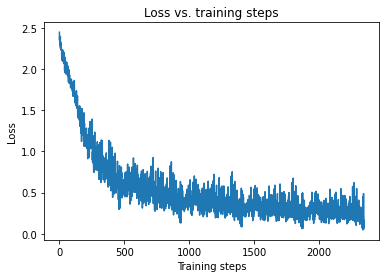

In [31]:
# Plot the loss curve 
plt.plot(losses)
plt.title('Loss vs. training steps')
plt.xlabel('Training steps')
plt.ylabel('Loss')

In [33]:
# Evaluation on the test set
eval_acc = model.eval(X_test, y_test)
print('Evaluation accuracy: {}'.format(eval_acc))

Evaluation accuracy: 0.928


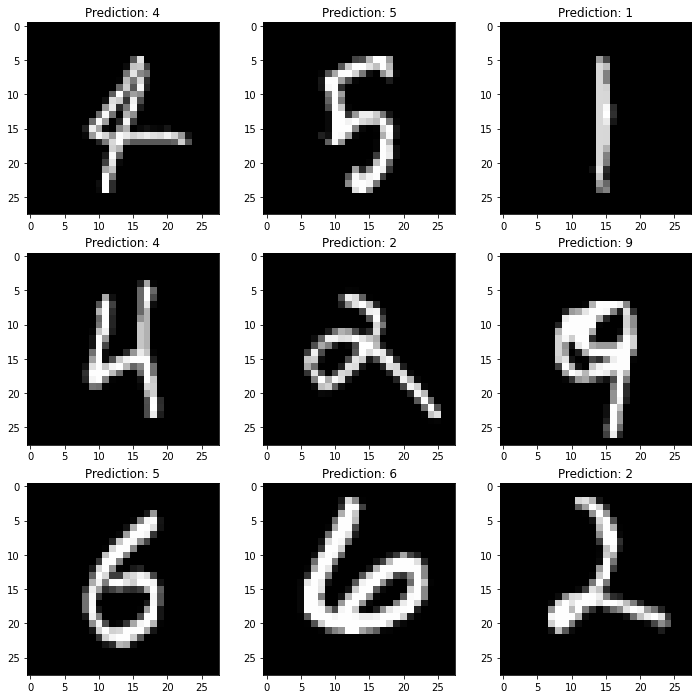

In [34]:
# Examples from the test set 
indices = np.random.randint(0, len(X_test), 9)
x_sample = X_test[indices, :]
y_sample = y_test[indices]

out, _ = model.forward(x_sample)
out = out - np.max(out, axis=1, keepdims=True)
numerator = np.exp(out)
probs = numerator / np.sum(numerator, axis=1, keepdims=True)
sample_predictions = np.argmax(probs, axis=1)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(9):
  r = i // 3
  c = i % 3
  axes[r, c].imshow(x_sample[i, :].squeeze(axis=0), cmap='gray')
  axes[r, c].set_title('Prediction: {}'.format(sample_predictions[i]))